In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet

# Sales Trend & Forecast
* Outliers Analysis 
* Forecasting horizon
* Time series cross validation 
* Lag features 
* Predicting the future 

# 1. Using Prophet Model 

# 1.1 Data Processing 

In [3]:
stores_data = pd.read_csv('customer_shopping_data.csv')
stores_data.columns

Index(['invoice_no', 'customer_id', 'gender', 'age', 'category', 'quantity',
       'price', 'payment_method', 'invoice_date', 'shopping_mall'],
      dtype='object')

In [4]:
sales_data = stores_data[['invoice_date','quantity','price']].sort_values(by='invoice_date').reset_index(drop=True)
sales_data['invoice_date'] = pd.to_datetime(sales_data['invoice_date'],format="%d/%m/%Y")
sales_data = sales_data.groupby('invoice_date').agg('sum')

sales_data

,quantity,price
invoice_date,,
2021-01-01,333,71524.88
2021-01-02,387,85257.90
2021-01-03,405,102892.65
2021-01-04,379,75425.08
2021-01-05,374,85855.16
...,...,...
2023-03-04,435,108199.45
2023-03-05,354,82844.41
2023-03-06,401,111230.13


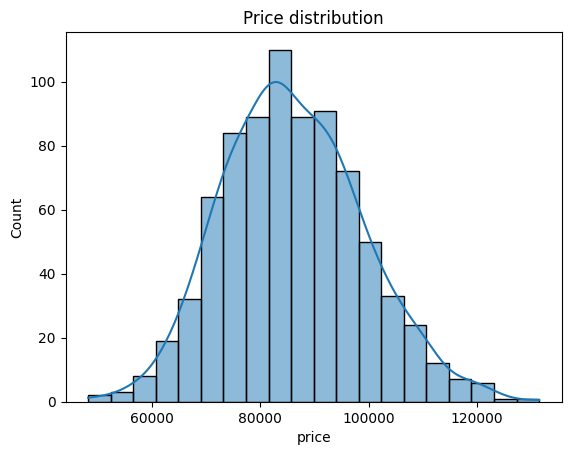

Text(0.5, 1.0, 'Quantity Distribution')

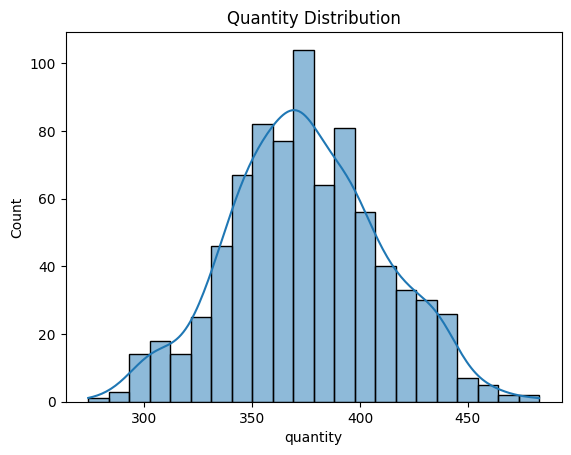

In [5]:
# sales_data['quantity'].hist()
sns.histplot(sales_data['price'],bins=20, kde=True)
plt.title('Price distribution')
plt.show()
sns.histplot(sales_data['quantity'],kde=True)
plt.title('Quantity Distribution')

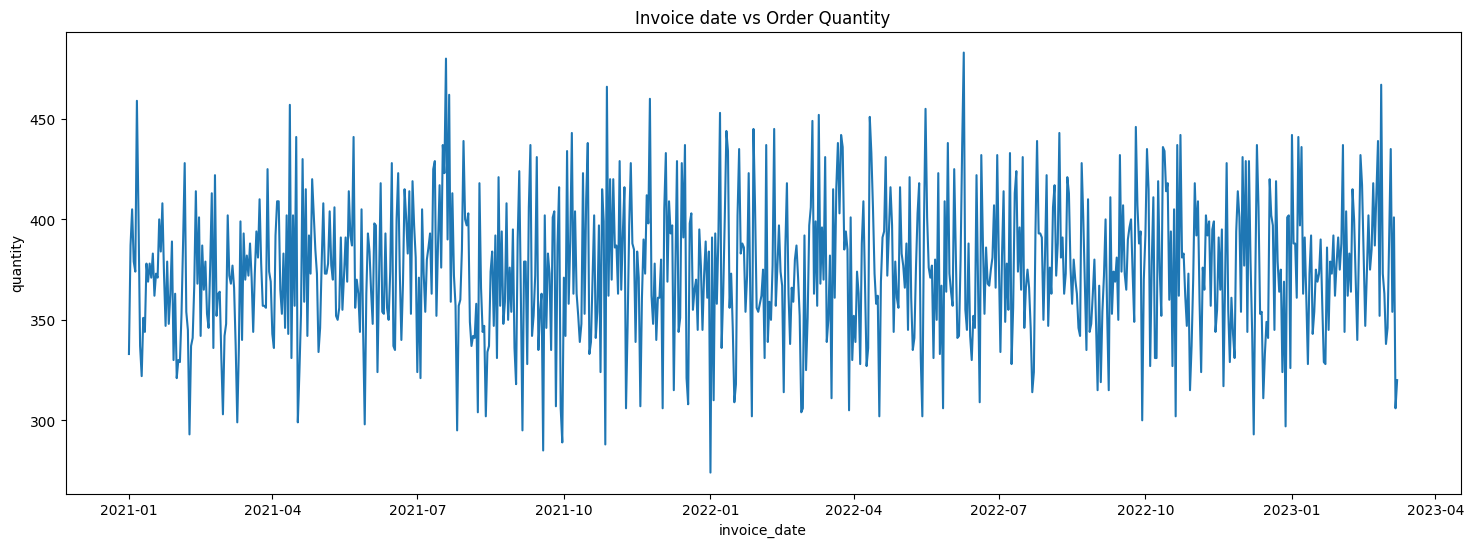

In [6]:
plt.figure(figsize=(18,6))
sns.lineplot(x=sales_data.index, y=sales_data['quantity'])
plt.title('Invoice date vs Order Quantity')
plt.show()

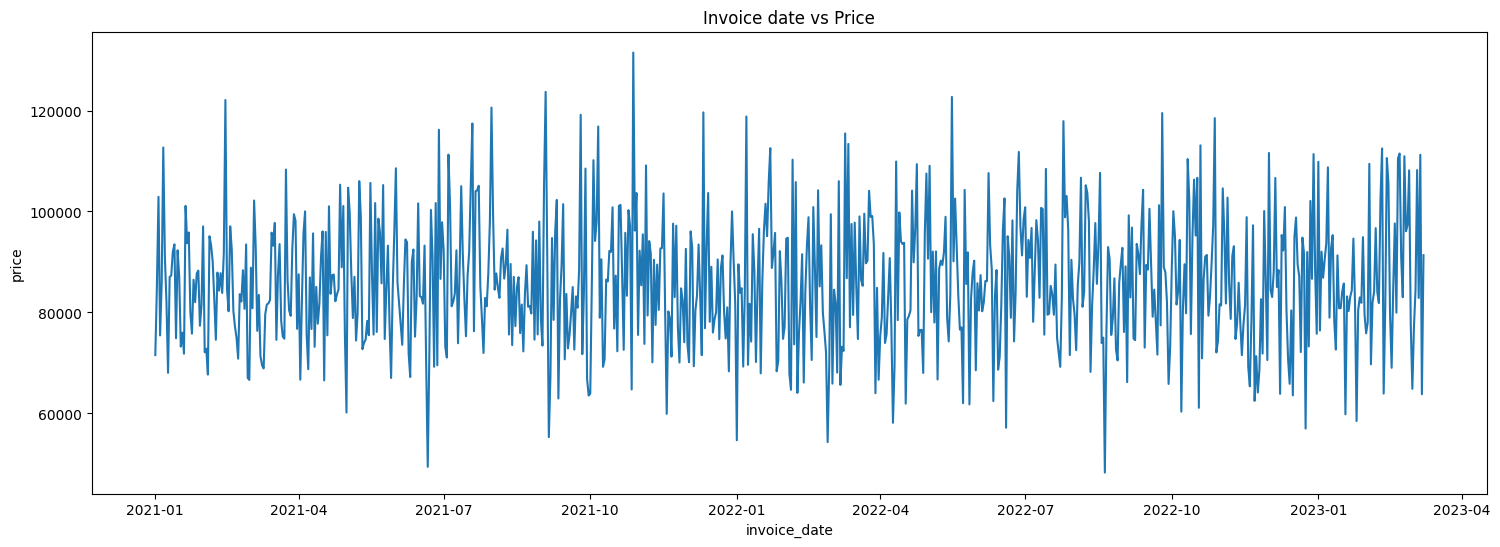

In [7]:
plt.figure(figsize=(18,6))
sns.lineplot(x=sales_data.index, y=sales_data['price'])
plt.title('Invoice date vs Price')
plt.show()

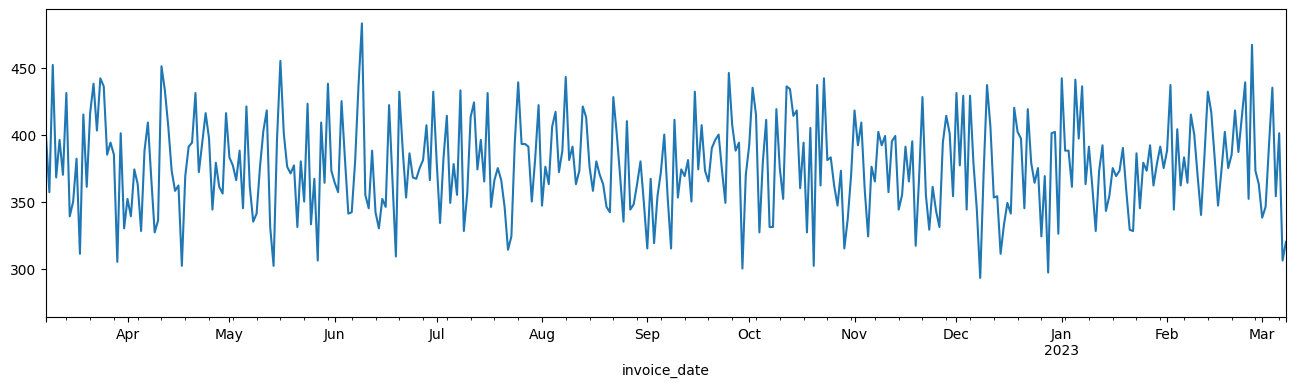

In [8]:

sales_data= sales_data[['quantity','price']]
sales_data['quantity'].plot(xlim=['2022-03-08','2023-03-08'], figsize=(16,4))
plt.show()

In [9]:
sales_data

,quantity,price
invoice_date,,
2021-01-01,333,71524.88
2021-01-02,387,85257.90
2021-01-03,405,102892.65
2021-01-04,379,75425.08
2021-01-05,374,85855.16
...,...,...
2023-03-04,435,108199.45
2023-03-05,354,82844.41
2023-03-06,401,111230.13


In [10]:
sales_data_to_forecast = pd.DataFrame()
sales_data_to_forecast['quantity'] =  sales_data.quantity
sales_data_to_forecast['price'] = sales_data.price
sales_data_to_forecast['date'] = sales_data.index
sales_data_to_forecast['year'] = [x.split('-')[0] for x in sales_data_to_forecast['date'].astype(str)]
sales_data_to_forecast['month'] = [x.split('-')[1] for x in sales_data_to_forecast['date'].astype(str)]
sales_data_to_forecast['day'] = [x.split('-')[-1] for x in sales_data_to_forecast['date'].astype(str)]
sales_data_to_forecast['day_of_week'] = sales_data_to_forecast['date'].dt.day_name()
sales_data_to_forecast = sales_data_to_forecast[['date','year','month','day','day_of_week','quantity','price']].reset_index(drop=True)
sales_data_to_forecast

,date,year,month,day,day_of_week,quantity,price
0,2021-01-01,2021,01,01,Friday,333,71524.88
1,2021-01-02,2021,01,02,Saturday,387,85257.90
2,2021-01-03,2021,01,03,Sunday,405,102892.65
3,2021-01-04,2021,01,04,Monday,379,75425.08
4,2021-01-05,2021,01,05,Tuesday,374,85855.16
...,...,...,...,...,...,...,...
792,2023-03-04,2023,03,04,Saturday,435,108199.45
793,2023-03-05,2023,03,05,Sunday,354,82844.41
794,2023-03-06,2023,03,06,Monday,401,111230.13
795,2023-03-07,2023,03,07,Tuesday,306,63766.67


In [527]:
sales_data_to_forecast.set_index('date',inplace=True)

### Rule A : Year end frequency 
### Rule QS : Quaterly 
sales_data_to_forecast.resample(rule='A').min()

C:\Users\Aaditya\AppData\Local\Temp\ipykernel_7244\4177859563.py:5: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  sales_data_to_forecast.resample(rule='A').min()


,year,month,day,day_of_week,quantity,price
date,,,,,,
2021-12-31,2021,01,01,Friday,285,49377.92
2022-12-31,2022,01,01,Friday,274,48241.60
2023-12-31,2023,01,01,Friday,306,58463.22


In [528]:
sales_data_to_forecast.resample(rule='A').max()

C:\Users\Aaditya\AppData\Local\Temp\ipykernel_7244\3902509116.py:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  sales_data_to_forecast.resample(rule='A').max()


,year,month,day,day_of_week,quantity,price
date,,,,,,
2021-12-31,2021,12,31,Wednesday,480,131481.80
2022-12-31,2022,12,31,Wednesday,483,122705.03
2023-12-31,2023,03,31,Wednesday,467,112480.58


In [529]:
split_date = '2023-01-01'

sales_data_train = sales_data_to_forecast[sales_data_to_forecast.index<split_date]
sales_data_test = sales_data_to_forecast[sales_data_to_forecast.index>=split_date]

# sales_data_train
# sales_data_test

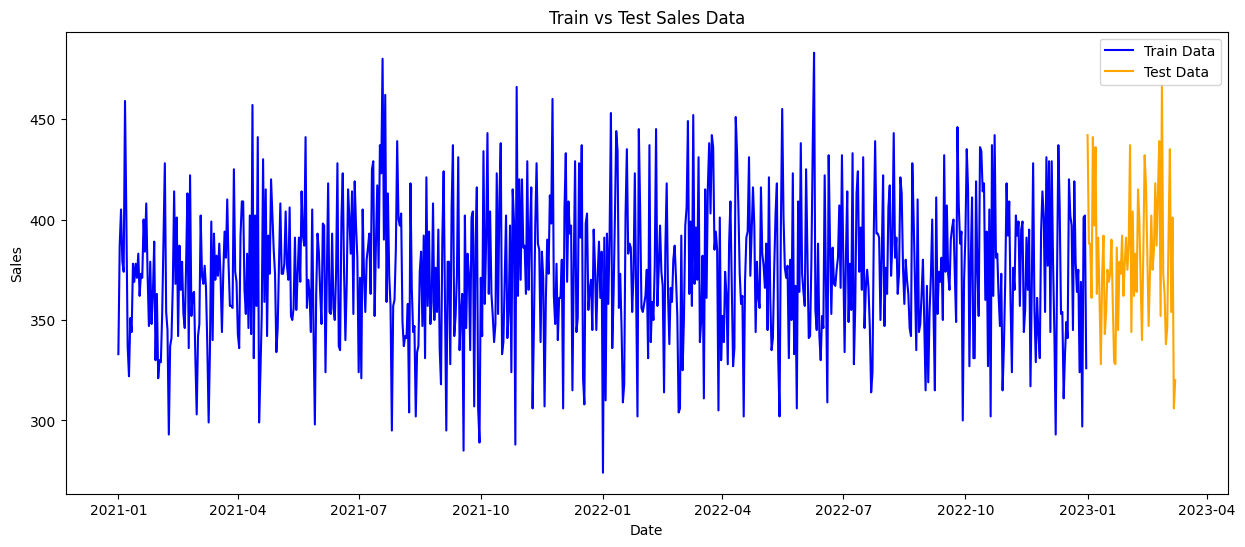

In [530]:
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(sales_data_train.index, sales_data_train['quantity'], label='Train Data', color='blue')

# Plot testing data
plt.plot(sales_data_test.index, sales_data_test['quantity'], label='Test Data', color='orange')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Train vs Test Sales Data')
plt.legend()

# Show the plot
plt.show()

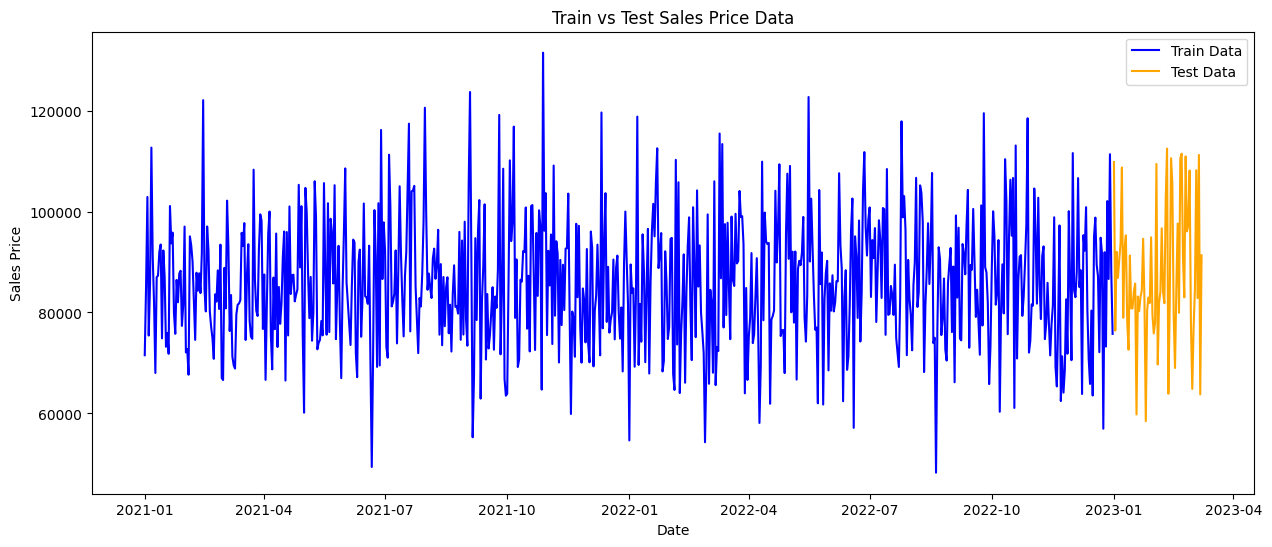

In [531]:
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(sales_data_train.index, sales_data_train['price'], label='Train Data', color='blue')

# Plot testing data
plt.plot(sales_data_test.index, sales_data_test['price'], label='Test Data', color='orange')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Sales Price')
plt.title('Train vs Test Sales Price Data')
plt.legend()

# Show the plot
plt.show()

# 1.2 Prophet Model Selection & Training

In [532]:
train_data = sales_data_train.reset_index().rename(columns={'date':'ds','quantity':'y'})
test_data = sales_data_test.reset_index().rename(columns={'date':'ds','quantity':'y'})
train_data = train_data[['ds','y']]
test_data = test_data[['ds','y']]
print('Train data:', train_data['ds'][0],'to',train_data['ds'].max(),'\nTotal length:',len(train_data))
print('Test data:',test_data['ds'][0],'to',test_data['ds'].max(),'\nTotal length:',len(test_data))

Train data: 2021-01-01 00:00:00 to 2022-12-31 00:00:00 
Total length: 730
Test data: 2023-01-01 00:00:00 to 2023-03-08 00:00:00 
Total length: 67


In [533]:
train_data = sales_data_to_forecast.reset_index().rename(columns={'date':'ds','quantity':'y'})

In [534]:
%time
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True)
model.fit(train_data)

CPU times: total: 0 ns
Wall time: 0 ns


21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:07 - cmdstanpy - INFO - Chain [1] done processing


In [535]:
model.component_modes

{'additive': ['additive_terms', 'extra_regressors_additive'],
 'multiplicative': ['yearly',
  'weekly',
  'multiplicative_terms',
  'extra_regressors_multiplicative',
  'holidays']}

In [536]:
forecasted_test_data = model.predict(test_data)

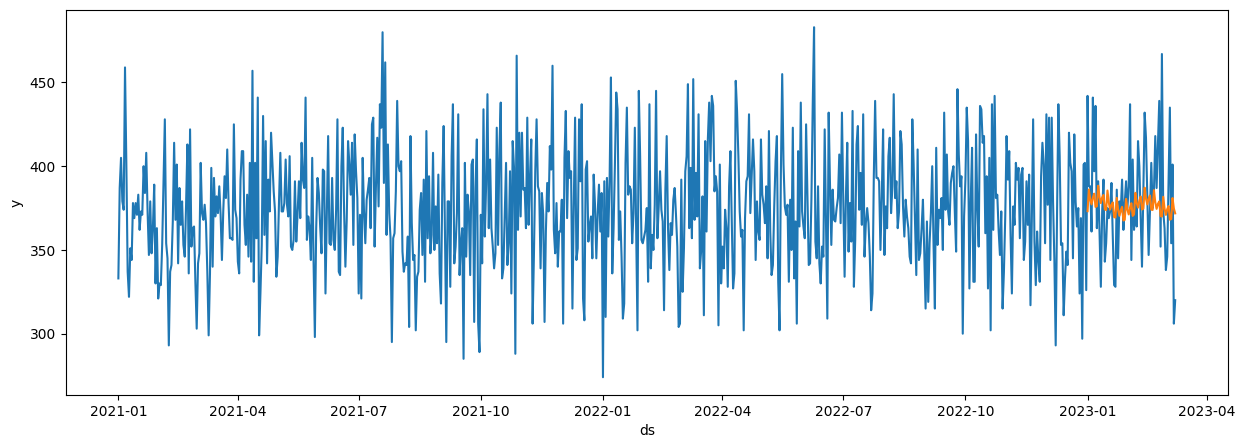

In [537]:
# fig, ax = plt.subplots(figsize=(15,5))
# fig = model.plot(forecasted_test_data, ax=ax)
# ax.set_title('Forecast')
# plt.show()

plt.figure(figsize=(15,5))
sns.lineplot(x=train_data['ds'], y=train_data['y'])
sns.lineplot(x=forecasted_test_data['ds'], y=forecasted_test_data['yhat'])
plt.show()

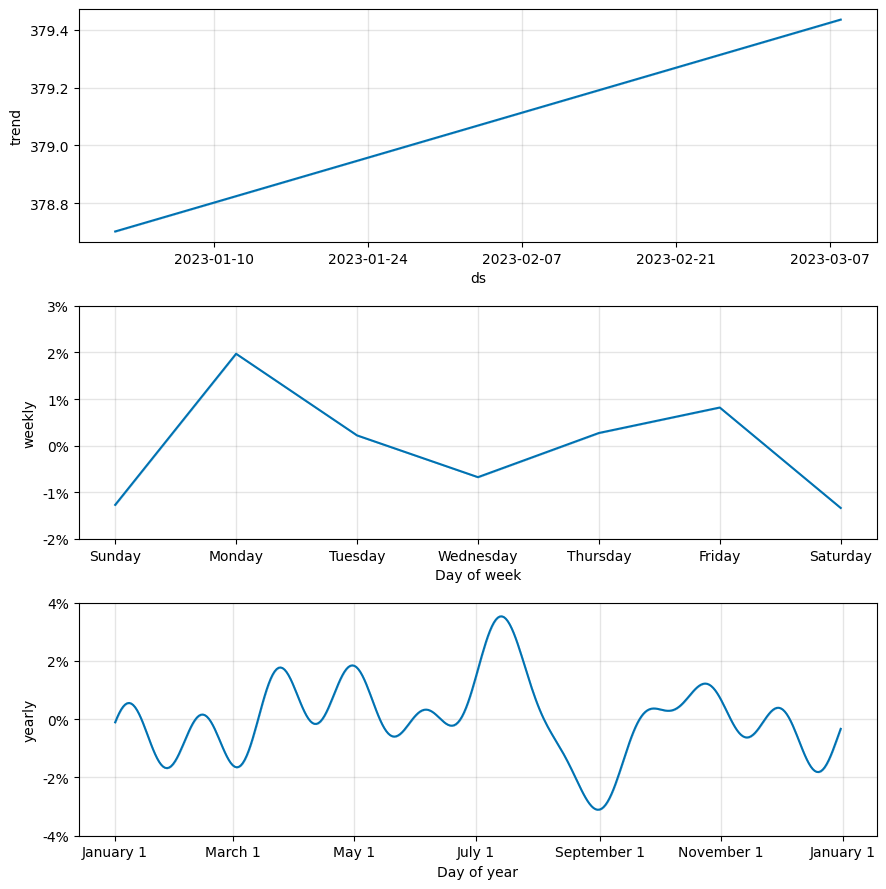

In [538]:
fig = model.plot_components(forecasted_test_data)
plt.show()

# 1.3  Actual vs Forecasted 

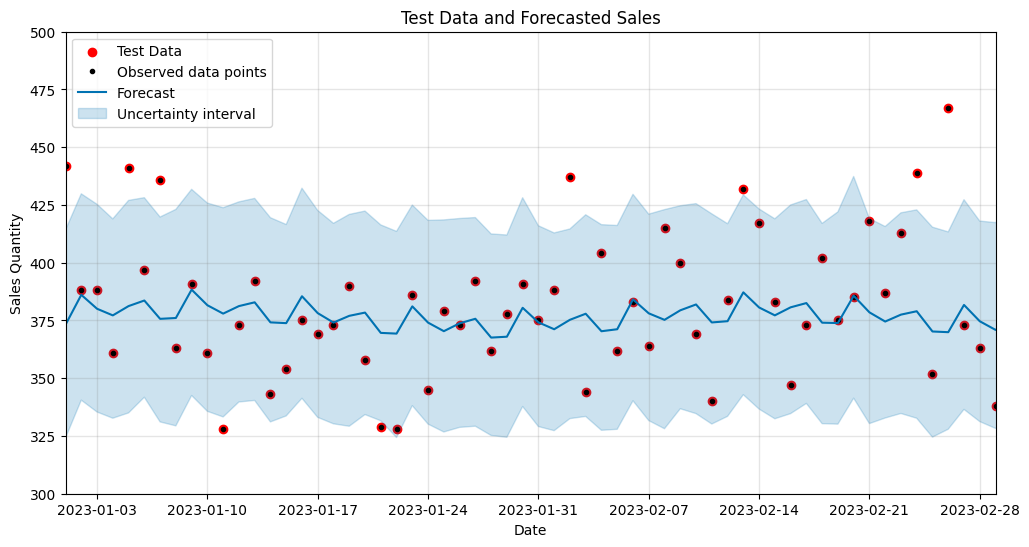

In [539]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(x=test_data['ds'], y=test_data['y'], color='r', label='Test Data')
fig = model.plot(forecasted_test_data, ax=ax)


ax.set_xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-03-01'))  # Set x-limits as datetime objects
ax.set_ylim(300, 500)  # Set y-limits


ax.set_xlabel('Date')
ax.set_ylabel('Sales Quantity')
ax.set_title('Test Data and Forecasted Sales')


plt.legend()
plt.show()


In [540]:
forecasted_test_data[['ds','yhat']]

,ds,yhat
0,2023-01-01,373.155208
1,2023-01-02,386.094946
2,2023-01-03,380.067143
3,2023-01-04,377.200674
4,2023-01-05,381.228847
...,...,...
62,2023-03-04,368.066353
63,2023-03-05,368.445253
64,2023-03-06,380.999850
65,2023-03-07,374.737919


In [541]:
future = model.make_future_dataframe(periods=60, include_history=False, freq='d')
future_pred = model.predict(future)
future_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2023-03-09,379.446234,332.432186,419.046625,379.446234,379.446234,-0.008950,-0.008950,-0.008950,0.002719,0.002719,0.002719,-0.011669,-0.011669,-0.011669,0.0,0.0,0.0,376.050357
1,2023-03-10,379.457337,334.175239,422.548111,379.457337,379.457337,-0.001628,-0.001628,-0.001628,0.008184,0.008184,0.008184,-0.009812,-0.009812,-0.009812,0.0,0.0,0.0,378.839518
2,2023-03-11,379.468439,327.756265,413.704599,379.468439,379.468439,-0.021091,-0.021091,-0.021091,-0.013364,-0.013364,-0.013364,-0.007727,-0.007727,-0.007727,0.0,0.0,0.0,371.464898
3,2023-03-12,379.479542,328.029482,417.960825,379.479542,379.479542,-0.018160,-0.018160,-0.018160,-0.012701,-0.012701,-0.012701,-0.005459,-0.005459,-0.005459,0.0,0.0,0.0,372.588029
4,2023-03-13,379.490644,339.994617,426.202505,379.490644,379.490644,0.016659,0.016659,0.016659,0.019715,0.019715,0.019715,-0.003056,-0.003056,-0.003056,0.0,0.0,0.0,385.812503


In [542]:
future_pred[['ds','yhat']].head()

,ds,yhat
0,2023-03-09,376.050357
1,2023-03-10,378.839518
2,2023-03-11,371.464898
3,2023-03-12,372.588029
4,2023-03-13,385.812503


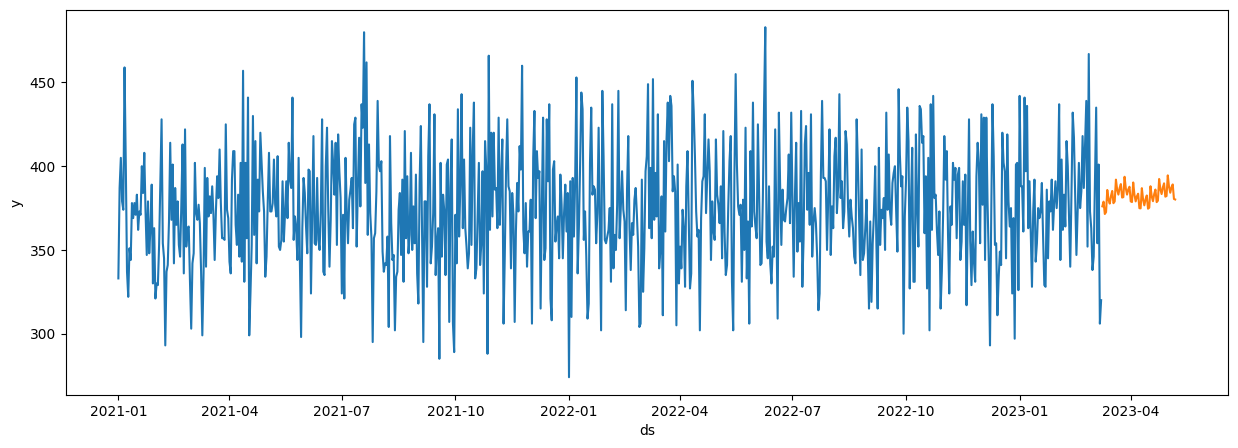

In [543]:
plt.figure(figsize=(15,5))
sns.lineplot(x=train_data['ds'], y=train_data['y'])
sns.lineplot(x=future_pred['ds'], y=future_pred['yhat'])
plt.show()

In [544]:
from prophet.diagnostics import performance_metrics, cross_validation

In [545]:
# initial='365 days': Train on the first 12 months (365 days).
# period='60 days': Retrain the model every 60 days.
# horizon='90 days': Forecast for 3 months into the future.
    
df_cv = cross_validation(model, initial='545 days', period='90 days', horizon='180 days')
df_cv

  0%|          | 0/1 [00:00<?, ?it/s]

21:52:11 - cmdstanpy - INFO - Chain [1] start processing
21:52:12 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-09-10,361.541867,316.476527,402.205379,353,2022-09-09
1,2022-09-11,356.654441,311.004907,399.067104,374,2022-09-09
2,2022-09-12,373.335213,329.109553,418.670302,369,2022-09-09
3,2022-09-13,369.275540,325.775355,412.810299,381,2022-09-09
4,2022-09-14,366.863831,323.017342,411.093858,350,2022-09-09
...,...,...,...,...,...,...
175,2023-03-04,367.932024,325.320069,408.744124,435,2022-09-09
176,2023-03-05,363.260313,319.373447,407.532315,354,2022-09-09
177,2023-03-06,380.277377,340.651237,428.193556,401,2022-09-09
178,2023-03-07,376.521389,331.425021,415.906347,306,2022-09-09


In [546]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
175,2023-03-04,367.932024,325.320069,408.744124,435,2022-09-09
176,2023-03-05,363.260313,319.373447,407.532315,354,2022-09-09
177,2023-03-06,380.277377,340.651237,428.193556,401,2022-09-09
178,2023-03-07,376.521389,331.425021,415.906347,306,2022-09-09
179,2023-03-08,374.466604,329.819408,420.030948,320,2022-09-09


In [547]:
evl = performance_metrics(df_cv)
evl

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days,982.271808,31.341216,23.078389,0.057262,0.046403,0.059873,0.888889
1,19 days,1009.389565,31.770892,23.919796,0.059257,0.047305,0.061988,0.888889
2,20 days,1269.464303,35.629543,26.877532,0.069752,0.048618,0.071046,0.833333
3,21 days,1269.524228,35.630383,26.884347,0.069769,0.048618,0.071062,0.833333
4,22 days,1297.434490,36.019918,27.638277,0.071644,0.054587,0.073031,0.833333
...,...,...,...,...,...,...,...,...
158,176 days,1600.174951,40.002187,30.117148,0.073842,0.055889,0.077360,0.833333
159,177 days,1595.726653,39.946547,29.916209,0.073427,0.055889,0.076894,0.833333
160,178 days,1589.487379,39.868376,29.774400,0.072572,0.048190,0.076236,0.833333
161,179 days,1865.721229,43.193995,33.635137,0.085222,0.062040,0.087564,0.777778


In [548]:
from prophet.plot import plot_cross_validation_metric

c:\Users\Aaditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\Aaditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


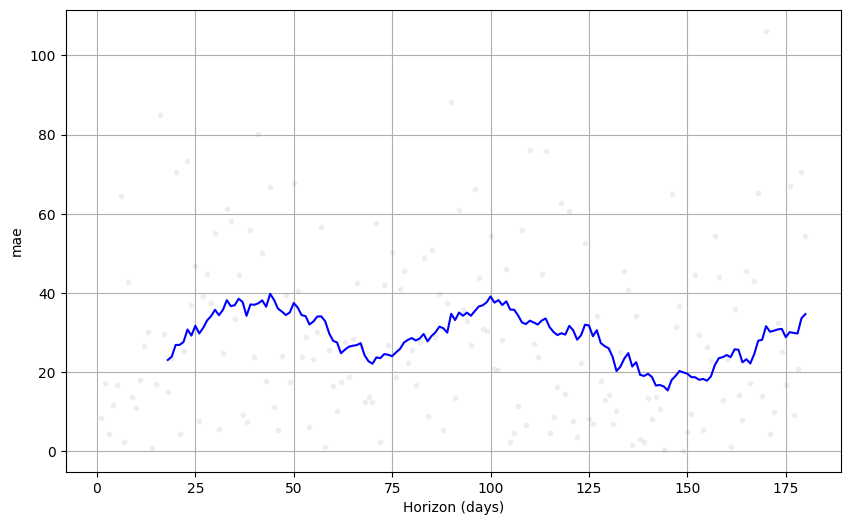

In [549]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

<Figure size 1500x500 with 0 Axes>

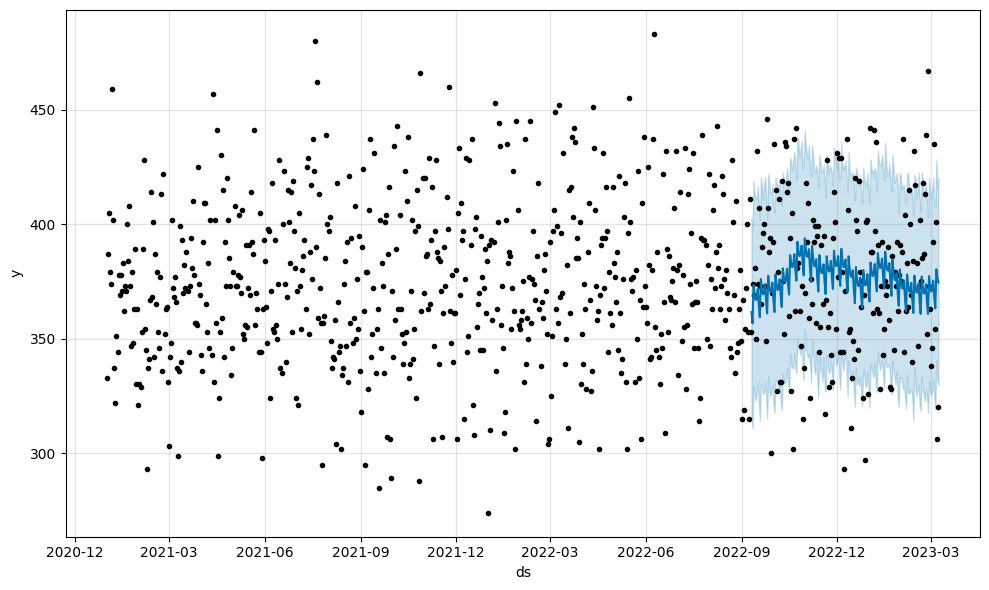

In [550]:
plt.figure(figsize=(15,5))
model.plot(df_cv)
plt.show()

# 2. Forecast using Regression 

In [639]:
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

In [747]:
store_sales_data = pd.read_csv('customer_shopping_data.csv')
store_sales_data = store_sales_data.sort_values(by='invoice_date')
store_sales_data

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
36199,I192911,C642829,Female,66,Food & Beverage,5,26.15,Credit Card,1/1/2021,Metrocity
45626,I371949,C260427,Male,50,Toys,2,71.68,Credit Card,1/1/2021,Metrocity
74986,I274757,C231715,Male,44,Cosmetics,2,81.32,Credit Card,1/1/2021,Mall of Istanbul
9456,I323282,C134774,Female,33,Shoes,5,3000.85,Cash,1/1/2021,Metrocity
36006,I263376,C600632,Female,50,Food & Beverage,5,26.15,Cash,1/1/2021,Metrocity
...,...,...,...,...,...,...,...,...,...,...
5443,I142487,C311273,Male,65,Shoes,1,600.17,Cash,9/9/2022,Metrocity
92297,I156458,C107947,Female,36,Shoes,3,1800.51,Credit Card,9/9/2022,Zorlu Center
45393,I162130,C569143,Male,44,Toys,1,35.84,Credit Card,9/9/2022,Emaar Square Mall
5555,I298518,C392548,Male,19,Clothing,4,1200.32,Debit Card,9/9/2022,Metrocity


# 2.1 Feature Engineering 

In [748]:
store_sales_data['invoice_date'] = pd.to_datetime(store_sales_data['invoice_date'], format='%d/%m/%Y')
store_sales_data['year'] = [int(x.split('-')[0]) for x in store_sales_data['invoice_date'].astype(str)]
store_sales_data['month'] = [int(x.split('-')[1]) for x in store_sales_data['invoice_date'].astype(str)]
store_sales_data['day'] = [int(x.split('-')[-1]) for x in store_sales_data['invoice_date'].astype(str)]
store_sales_data['day_of_week'] = store_sales_data['invoice_date'].dt.day_name()
store_sales_data = store_sales_data[['invoice_date','year','month','day','day_of_week','quantity','price','shopping_mall','category','payment_method']].reset_index(drop=True)
store_sales_data

,invoice_date,year,month,day,day_of_week,quantity,price,shopping_mall,category,payment_method
0,2021-01-01,2021,1,1,Friday,5,26.15,Metrocity,Food & Beverage,Credit Card
1,2021-01-01,2021,1,1,Friday,2,71.68,Metrocity,Toys,Credit Card
2,2021-01-01,2021,1,1,Friday,2,81.32,Mall of Istanbul,Cosmetics,Credit Card
3,2021-01-01,2021,1,1,Friday,5,3000.85,Metrocity,Shoes,Cash
4,2021-01-01,2021,1,1,Friday,5,26.15,Metrocity,Food & Beverage,Cash
...,...,...,...,...,...,...,...,...,...,...
99452,2022-09-09,2022,9,9,Friday,1,600.17,Metrocity,Shoes,Cash
99453,2022-09-09,2022,9,9,Friday,3,1800.51,Zorlu Center,Shoes,Credit Card
99454,2022-09-09,2022,9,9,Friday,1,35.84,Emaar Square Mall,Toys,Credit Card
99455,2022-09-09,2022,9,9,Friday,4,1200.32,Metrocity,Clothing,Debit Card


In [749]:
encoder = LabelEncoder()

store_sales_data['encoded_location'] =  encoder.fit_transform(store_sales_data['shopping_mall'])
store_sales_data['encoded_category'] = encoder.fit_transform(store_sales_data['category'])
store_sales_data['encoded_payment_method'] = encoder.fit_transform(store_sales_data['payment_method'])
store_sales_data['day_of_week'] = encoder.fit_transform(store_sales_data['day_of_week'])
store_sales_data = store_sales_data.drop(columns=['shopping_mall','category','payment_method'])
store_sales_data

,invoice_date,year,month,day,day_of_week,quantity,price,encoded_location,encoded_category,encoded_payment_method
0,2021-01-01,2021,1,1,0,5,26.15,6,3,1
1,2021-01-01,2021,1,1,0,2,71.68,6,7,1
2,2021-01-01,2021,1,1,0,2,81.32,5,2,1
3,2021-01-01,2021,1,1,0,5,3000.85,6,4,0
4,2021-01-01,2021,1,1,0,5,26.15,6,3,0
...,...,...,...,...,...,...,...,...,...,...
99452,2022-09-09,2022,9,9,0,1,600.17,6,4,0
99453,2022-09-09,2022,9,9,0,3,1800.51,9,4,1
99454,2022-09-09,2022,9,9,0,1,35.84,1,7,1
99455,2022-09-09,2022,9,9,0,4,1200.32,6,1,2


In [750]:
store_sales_data.describe()
# store_sales_data.info()

,invoice_date,year,month,day,day_of_week,quantity,price,encoded_location,encoded_category,encoded_payment_method
count,99457,99457.000000,99457.000000,99457.000000,99457.000000,99457.000000,99457.000000,99457.000000,99457.000000,99457.000000
mean,2022-02-04 02:46:59.783424,2021.629408,6.113898,15.569603,2.989895,3.003429,689.256321,4.717969,2.762249,0.754990
min,2021-01-01 00:00:00,2021.000000,1.000000,1.000000,0.000000,1.000000,5.230000,0.000000,0.000000,0.000000
25%,2021-07-19 00:00:00,2021.000000,3.000000,8.000000,1.000000,2.000000,45.450000,4.000000,1.000000,0.000000
50%,2022-02-05 00:00:00,2022.000000,6.000000,16.000000,3.000000,3.000000,203.300000,5.000000,2.000000,1.000000
75%,2022-08-22 00:00:00,2022.000000,9.000000,23.000000,5.000000,4.000000,1200.320000,6.000000,4.000000,1.000000
max,2023-03-08 00:00:00,2023.000000,12.000000,31.000000,6.000000,5.000000,5250.000000,9.000000,7.000000,2.000000
std,NaN,0.636136,3.569511,8.799894,2.002559,1.413025,941.184567,2.193189,2.076012,0.767306


In [751]:
store_sales_data['invoice_date'].duplicated().sum()

98660

In [752]:
print(store_sales_data.dtypes)

invoice_date              datetime64[ns]
year                               int64
month                              int64
day                                int64
day_of_week                        int32
quantity                           int64
price                            float64
encoded_location                   int32
encoded_category                   int32
encoded_payment_method             int32
dtype: object


In [753]:
store_sales_data = store_sales_data.groupby(['invoice_date','encoded_category']).agg(
    sales_quantity = ('quantity','sum'),
    sales_amount = ('price','sum')
)
# store_sales_data.rename(columns={'quantity':'sales_quantity','price':'sales_amount'},inplace=True)
store_sales_data = store_sales_data.reset_index()
store_sales_data.set_index('invoice_date',inplace=True)
# store_sales_data = store_sales_data.resample('D').sum()
store_sales_data

,encoded_category,sales_quantity,sales_amount
invoice_date,,,
2021-01-01,0,21,318.15
2021-01-01,1,81,24306.48
2021-01-01,2,55,2236.30
2021-01-01,3,49,256.27
2021-01-01,4,50,30008.50
...,...,...,...
2023-03-08,3,40,209.20
2023-03-08,4,49,29408.33
2023-03-08,5,11,129.03


In [754]:
from statsmodels.tsa.stattools import adfuller

# Check if the series is stationary
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("Series is non-stationary. Differencing is needed.")
    else:
        print("Series is stationary.")

adf_test(store_sales_data['sales_quantity'])
# if data is stationary no need to create differencing transformation , simply need some lag features 

ADF Statistic: -13.414752025700317
p-value: 4.304067874171187e-25
Series is stationary.


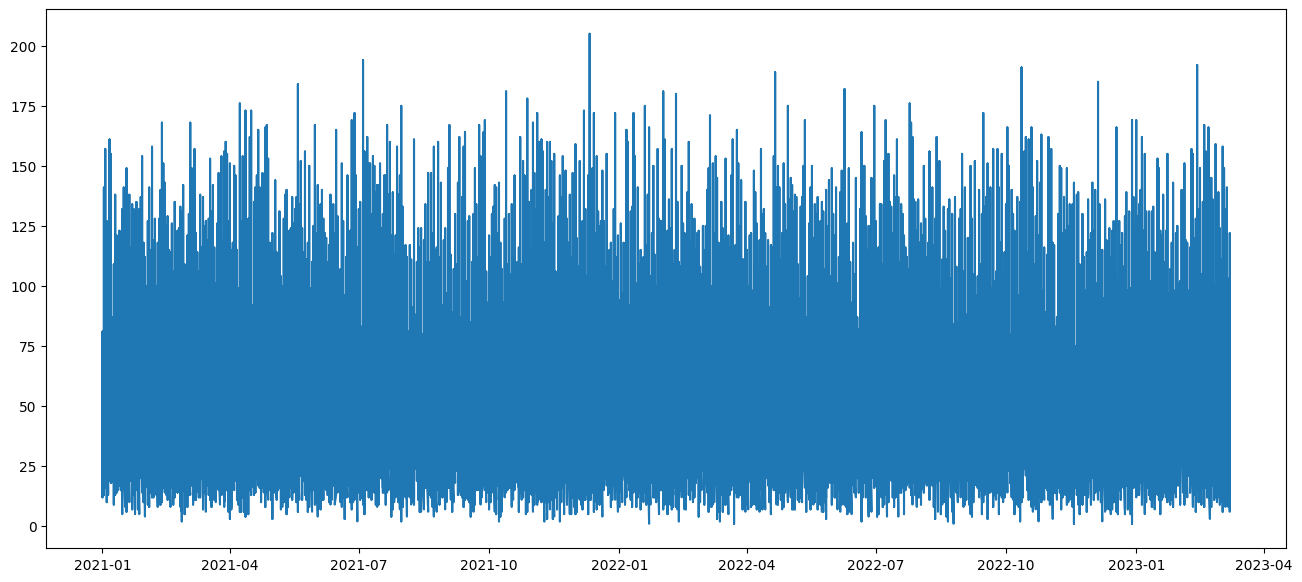

In [755]:

plt.figure(figsize=(16,7))
store_sales_data = store_sales_data.reset_index()
plt.plot(store_sales_data['invoice_date'],store_sales_data['sales_quantity'])
plt.show()

<Figure size 1000x600 with 0 Axes>

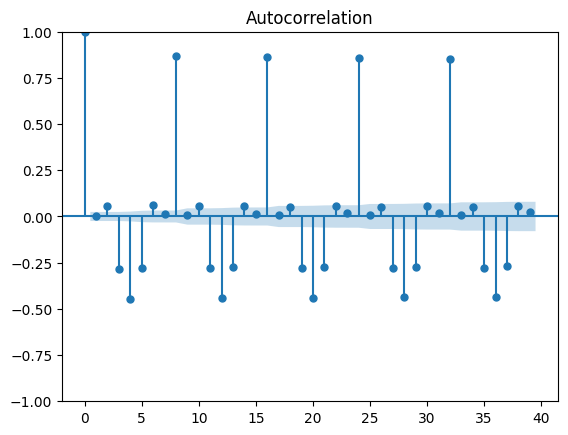

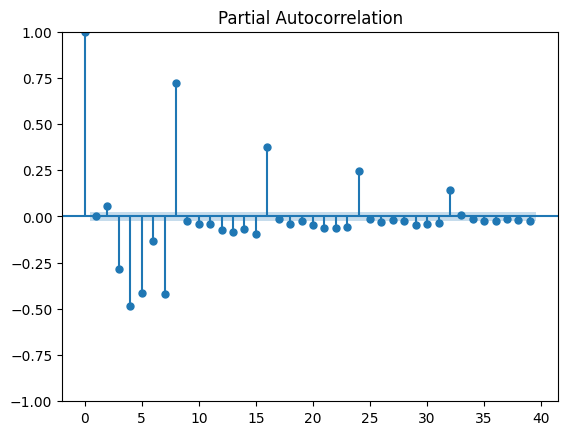

In [756]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(10,6))
plot_acf(store_sales_data['sales_quantity'],alpha=0.05)

plot_pacf(store_sales_data['sales_quantity'],alpha=0.05)
plt.show()

In [757]:
# create lag features 
store_sales_data['day_1'] = store_sales_data['sales_quantity'].shift(1) 
store_sales_data['day_2'] = store_sales_data['sales_quantity'].shift(2) 
store_sales_data['day_3'] = store_sales_data['sales_quantity'].shift(3) 
store_sales_data['day_4'] = store_sales_data['sales_quantity'].shift(4) 
store_sales_data['day_5'] = store_sales_data['sales_quantity'].shift(5) 
store_sales_data['day_6'] = store_sales_data['sales_quantity'].shift(6) 
store_sales_data['day_7'] = store_sales_data['sales_quantity'].shift(7)
store_sales_data = store_sales_data.dropna()
store_sales_data = store_sales_data.drop(columns=['sales_amount'],axis=1)
store_sales_data

,invoice_date,encoded_category,sales_quantity,day_1,day_2,day_3,day_4,day_5,day_6,day_7
7,2021-01-01,7,43,12.0,22.0,50.0,49.0,55.0,81.0,21.0
8,2021-01-02,0,20,43.0,12.0,22.0,50.0,49.0,55.0,81.0
9,2021-01-02,1,141,20.0,43.0,12.0,22.0,50.0,49.0,55.0
10,2021-01-02,2,40,141.0,20.0,43.0,12.0,22.0,50.0,49.0
11,2021-01-02,3,71,40.0,141.0,20.0,43.0,12.0,22.0,50.0
...,...,...,...,...,...,...,...,...,...,...
6366,2023-03-08,3,40,60.0,122.0,6.0,35.0,15.0,11.0,21.0
6367,2023-03-08,4,49,40.0,60.0,122.0,6.0,35.0,15.0,11.0
6368,2023-03-08,5,11,49.0,40.0,60.0,122.0,6.0,35.0,15.0
6369,2023-03-08,6,21,11.0,49.0,40.0,60.0,122.0,6.0,35.0


In [758]:
print(store_sales_data.isna().sum())
store_sales_data.shape

invoice_date        0
encoded_category    0
sales_quantity      0
day_1               0
day_2               0
day_3               0
day_4               0
day_5               0
day_6               0
day_7               0
dtype: int64


(6364, 10)

<Axes: >

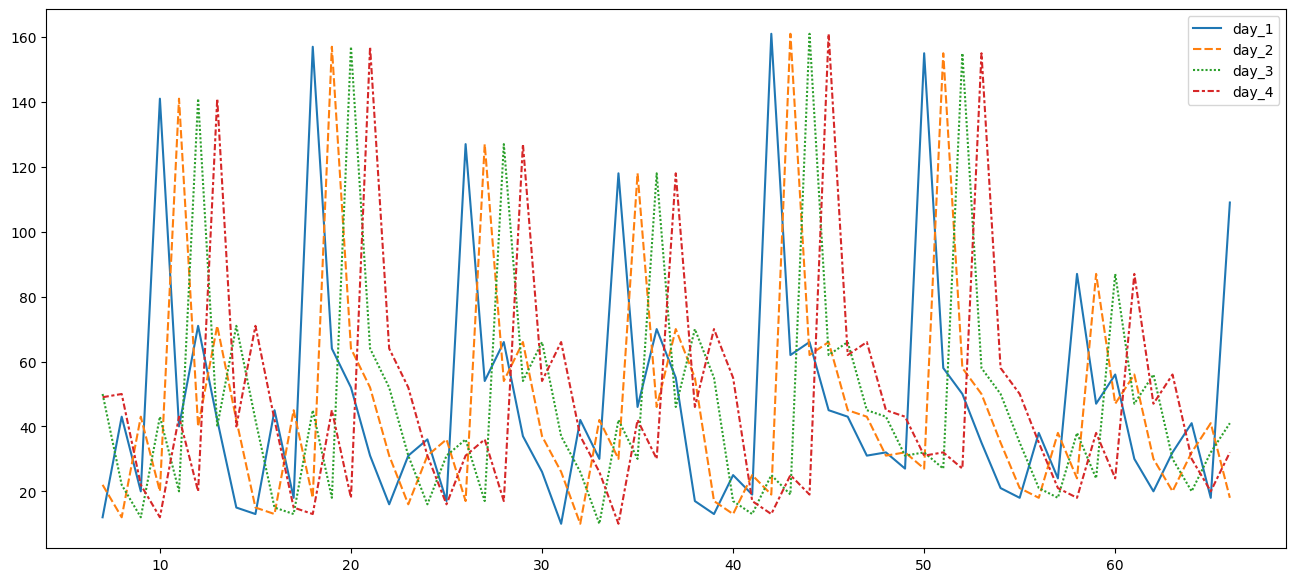

In [759]:
plt.figure(figsize=(16,7))
sns.lineplot(store_sales_data[['day_1','day_2','day_3','day_4']][:60])

In [760]:
correlation_matrix = store_sales_data.corr()
# print(correlation_matrix)

sales_correlation = correlation_matrix['sales_quantity']
print(sales_correlation)


invoice_date        0.007529
encoded_category   -0.407576
sales_quantity      1.000000
day_1               0.003448
day_2               0.058164
day_3              -0.283776
day_4              -0.446262
day_5              -0.278962
day_6               0.059508
day_7               0.011125
Name: sales_quantity, dtype: float64


In [798]:
x = store_sales_data[['day_2','day_3','day_4','day_5','encoded_category']]
y =  store_sales_data['sales_quantity']


In [799]:
X_train,X_test,y_train,y_test = x[:5000],x[5000:],y[:5000],y[5000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5000, 5)
(1364, 5)
(5000,)
(1364,)


In [800]:
X_train

,day_2,day_3,day_4,day_5,encoded_category
7,22.0,50.0,49.0,55.0,7
8,12.0,22.0,50.0,49.0,0
9,43.0,12.0,22.0,50.0,1
10,20.0,43.0,12.0,22.0,2
11,141.0,20.0,43.0,12.0,3
...,...,...,...,...,...
5002,3.0,41.0,46.0,52.0,7
5003,15.0,3.0,41.0,46.0,0
5004,49.0,15.0,3.0,41.0,1
5005,26.0,49.0,15.0,3.0,2


# 2.2 RandomForestRegressor 

In [810]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

In [811]:
print("R Sq. Score for Random Forest Regression :", rf_regressor.score(X_test, y_test))


R Sq. Score for Random Forest Regression : 0.857097788932739


In [812]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("MAPE:", mape)

Mean Absolute Error: 10.674149560117304
Mean Squared Error: 193.42636143695017
MAPE: 38.85133266844552


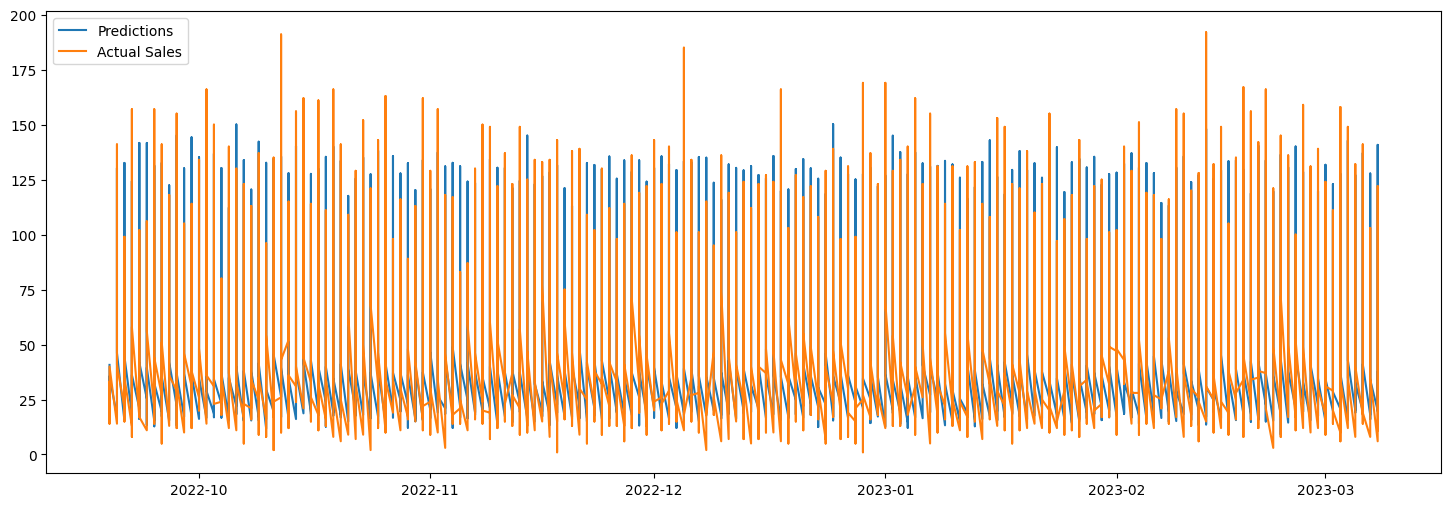

In [818]:
import matplotlib.pyplot as plt
plt.figure(figsize = (18,6))
dates = store_sales_data['invoice_date'][5000:] 
plt.plot(dates,y_pred, label='Predictions')
plt.plot(dates,y_test, label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

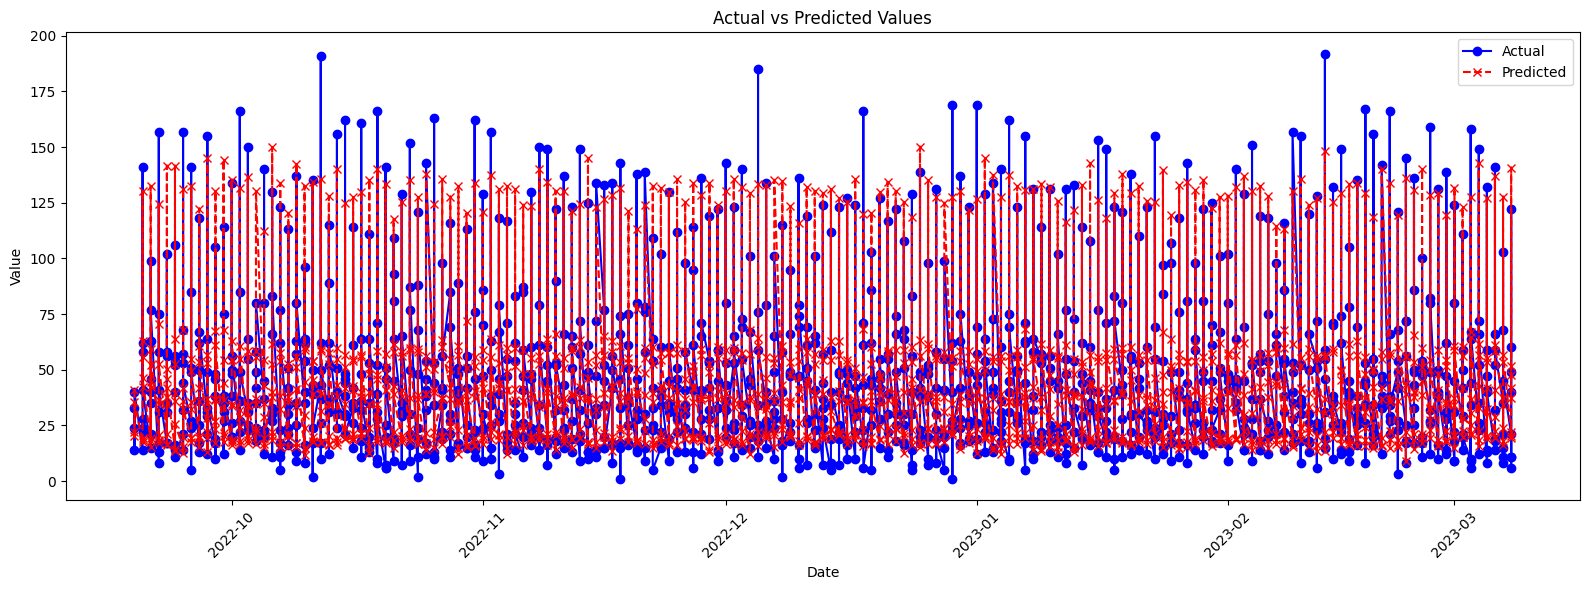

In [815]:
dates = store_sales_data['invoice_date'][5000:] 

# Create a DataFrame for actual vs predicted values
comparison_df = pd.DataFrame({'Date': dates, 'Actual': y_test, 'Predicted': y_pred})

# Sort the DataFrame by date to ensure the x-axis is in chronological order
comparison_df.sort_values('Date', inplace=True)

# Plotting the actual vs predicted values
plt.figure(figsize=(16, 6))
plt.plot(comparison_df['Date'], comparison_df['Actual'], label='Actual', color='blue', marker='o')
plt.plot(comparison_df['Date'], comparison_df['Predicted'], label='Predicted', color='red', linestyle='--', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [804]:
X_train.dtypes

day_2               float64
day_3               float64
day_4               float64
day_5               float64
encoded_category      int32
dtype: object

# 2.3 XGBRegressor 

In [805]:
import xgboost
xgb_regressor = xgboost.XGBRegressor()
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

In [806]:
print("R Sq. Score for XGBoost :", xgb_regressor.score(X_test, y_test))


R Sq. Score for XGBoost : 0.8456476330757141


In [807]:
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("MAPE:", mape)

Mean Absolute Error: 11.010280857337884
Mean Squared Error: 208.92478629093412
MAPE: 39.12927690951029


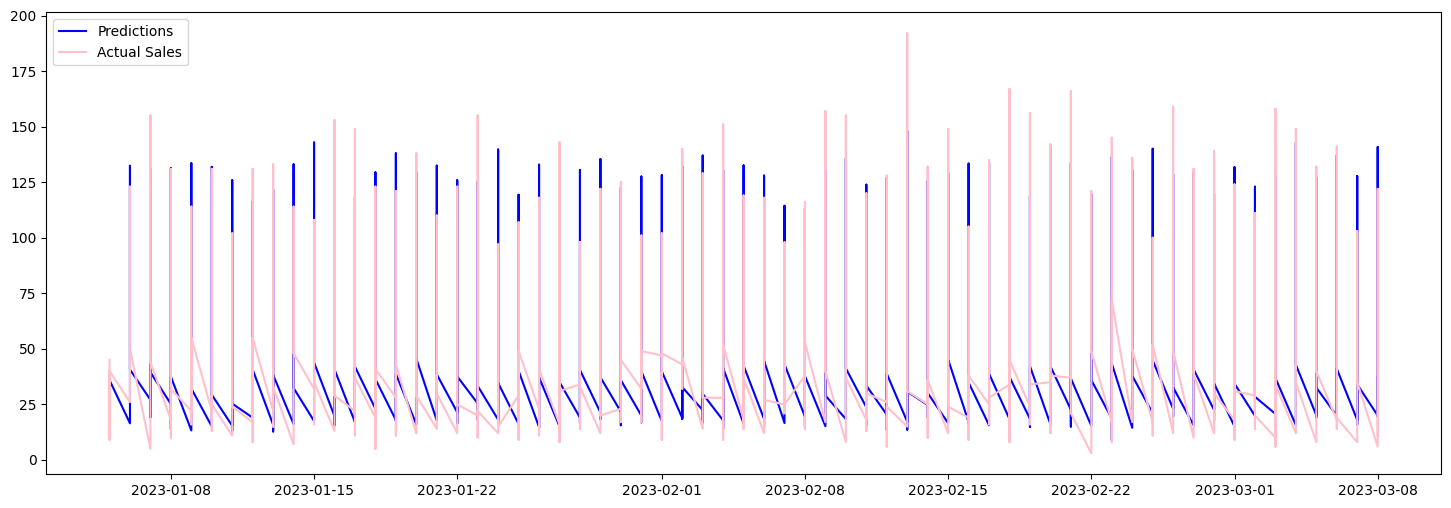

In [825]:
plt.figure(figsize = (18,6))
dates = store_sales_data['invoice_date'][5000:][-500:] 
plt.plot(dates,y_pred[-500:], label='Predictions',color='blue')
plt.plot(dates,y_test[-500:], label='Actual Sales',color='pink')
plt.legend(loc="upper left")
plt.show()